In [1]:
# Initiate the spark session

from pyspark.sql import SparkSession
from pyspark import SparkContext, SparkConf


In [2]:
# Import essential packages into python

import os
import pyspark
import random
import numpy as np
from numpy import array
from math import sqrt
import matplotlib.pyplot as plt
from matplotlib.pyplot import plot as plt

# sc.setCheckpointDir('checkpoint')

sc = SparkSession.builder.appName("Homework 2").getOrCreate()

# Retrieve the essential spark packages
from numpy import array
from math import sqrt
from pyspark.ml.clustering import KMeans
from pyspark.ml.feature import VectorAssembler, CountVectorizer
from pyspark.sql.functions import col, explode, split
from pyspark.ml.evaluation import ClusteringEvaluator
from pyspark.sql import functions as f



In [3]:
print('-------------------------- QUESTION 1 --------------------------')

-------------------------- QUESTION 1 --------------------------


In [4]:
# import the csv into spark

movies = sc.read.option("header","true").option("inferSchema","true").format("csv")\
.load("movies.csv")
ratings = sc.read.option("header","true").option("inferSchema","true").format("csv")\
.load("ratings.csv")

In [5]:
# Join both the data frames to add movie data into ratings data frame so we can see everything together

movie_ratings = ratings.join(movies, ['movieId'], 'left')
movie_ratings.show()


+-------+------+------+---------+--------------------+--------------------+
|MovieID|userID|Rating|TimeStamp|               Title|              Genres|
+-------+------+------+---------+--------------------+--------------------+
|   1193|     1|     5|978300760|One Flew Over the...|               Drama|
|    661|     1|     3|978302109|James and the Gia...|Animation|Childre...|
|    914|     1|     3|978301968| My Fair Lady (1964)|     Musical|Romance|
|   3408|     1|     4|978300275|Erin Brockovich (...|               Drama|
|   2355|     1|     5|978824291|Bug's Life, A (1998)|Animation|Childre...|
|   1197|     1|     3|978302268|Princess Bride, T...|Action|Adventure|...|
|   1287|     1|     5|978302039|      Ben-Hur (1959)|Action|Adventure|...|
|   2804|     1|     5|978300719|Christmas Story, ...|        Comedy|Drama|
|    594|     1|     4|978302268|Snow White and th...|Animation|Childre...|
|    919|     1|     4|978301368|Wizard of Oz, The...|Adventure|Childre...|
|    595|   

In [6]:
# We need to change the genre from strings to array of strings.
# movie_ratings will have the genre column changed to an array of strings make sure you save the changes to another variable

movie_mod = movie_ratings.withColumn('Genres',split(col('Genres'),'\|').alias('Genres')).drop('TimeStamp')
                      

In [7]:
# here you can see the changes we correctly made

movie_mod.show()

+-------+------+------+--------------------+--------------------+
|MovieID|userID|Rating|               Title|              Genres|
+-------+------+------+--------------------+--------------------+
|   1193|     1|     5|One Flew Over the...|             [Drama]|
|    661|     1|     3|James and the Gia...|[Animation, Child...|
|    914|     1|     3| My Fair Lady (1964)|  [Musical, Romance]|
|   3408|     1|     4|Erin Brockovich (...|             [Drama]|
|   2355|     1|     5|Bug's Life, A (1998)|[Animation, Child...|
|   1197|     1|     3|Princess Bride, T...|[Action, Adventur...|
|   1287|     1|     5|      Ben-Hur (1959)|[Action, Adventur...|
|   2804|     1|     5|Christmas Story, ...|     [Comedy, Drama]|
|    594|     1|     4|Snow White and th...|[Animation, Child...|
|    919|     1|     4|Wizard of Oz, The...|[Adventure, Child...|
|    595|     1|     5|Beauty and the Be...|[Animation, Child...|
|    938|     1|     4|         Gigi (1958)|           [Musical]|
|   2398| 

In [8]:
# From here we can make preperations to do the kmeans algorithm

cvec = CountVectorizer(inputCol = 'Genres', outputCol = "features")

model = cvec.fit(movie_mod)
tmp = model.transform(movie_mod)

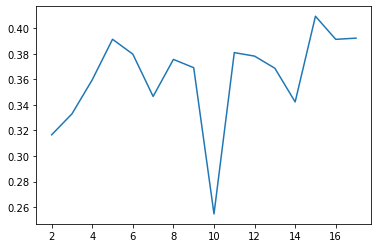

In [9]:
def plot_Sil_k_means(input, maxClust):
    sil_count_vec = []
    x = [*range(2, maxClust, 1)]
    for value in x:
        kmeans = KMeans().setK(value).setSeed(2021)
        model_cvec = kmeans.fit(input)
        preds = model_cvec.transform(input)
        eval_CV = ClusteringEvaluator()
        silh_CV = eval_CV.evaluate(preds)
        sil_count_vec.append(silh_CV)
    plt(x, sil_count_vec)    

plot_Sil_k_means(tmp, 18)    

In [10]:
# here we will define our k means and use k=5 as our optimal K

model_kmeans = KMeans().setK(5).setSeed(209)


In [11]:
# then We will apply the model to our dataset.

movie_ratings_kmeans = model_kmeans.fit(tmp)

In [12]:
# set up the predictions and from there find the RSME  

prediction = movie_ratings_kmeans.transform(tmp)\
                             .sort("userID")\
                             .drop("Features").withColumnRenamed("prediction", "cluster")

movie_ratings_2 = prediction.groupby("cluster", "userID").avg("rating").sort("userID")
movie_ratings_2 = prediction.join(movie_ratings_2, ["cluster", "userID"], "left").sort("userID")

movie_ratings_2 = movie_ratings_2.withColumn("diff", pow(movie_ratings_2["avg(rating)"] - movie_ratings_2["rating"], 2))

RSME = movie_ratings_2.groupBy().agg(f.sqrt(f.sum("diff")/f.count("diff"))).collect()

RSME


[Row(SQRT((sum(diff) / count(diff)))=0.9967508344070068)]